# Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers, Model

import preprocessing       
import models

In [2]:
print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Tensorflow version:', tf.__version__)

Pandas version: 2.2.1
Numpy version: 1.26.4
Tensorflow version: 2.16.1


In [3]:
# Hyperparams

output_dim = 1
freq='h'

batch_size = 128
epochs = 20

file_path = '../Daten/GermanSolarFarm/Imputed/pv_1.csv' # '../Daten/EuropeWindFarm/Imputed/wf1.csv' # 
target_col = 'power_normed' #'Active_Power'
timestamp_col = 'timestamp' #'timestamp'
train_end = '2022-03-31' #'2017-12-31'
test_start = '2022-04-01' #'2018-01-01'

# file_path = '../Daten/GermanSolarFarm/Imputed/pv_5.csv'
# target_col = 'power_normed' #'Active_Power'
# timestamp_col = 'timestamp' #'timestamp'
# train_end = '2021-12-31' #'2017-12-31'
# test_start = '2022-01-01' #'2018-01-01'

# file_path = '../Daten/1B_Trina.csv'
# timestamp_col = 'timestamp'
# target_col = 'Active_Power'
# freq = 'h'
# rel_features = [target_col, 'Global_Horizontal_Radiation', 'Weather_Temperature_Celsius', 'Diffuse_Horizontal_Radiation']
# train_end = '2017-12-31'
# test_start = '2018-01-01'

In [4]:
# Data preprocessing

data= pd.read_csv(file_path)

df = preprocessing.germansolarfarm(data, timestamp_col, target_col)
#df = preprocessing.europewindfarm(data, timestamp_col, target_col)
#df = preprocessing.preprocess_1b_trina(df,timestamp_col,target_col,freq)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18648 entries, 2020-11-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SolarRadiationGlobalAt0   18648 non-null  float64
 1   sunposition_solarAzimuth  18648 non-null  float64
 2   TemperatureAt0            18648 non-null  float64
 3   RelativeHumidityAt0       18648 non-null  float64
 4   power_normed              18648 non-null  float64
dtypes: float64(5)
memory usage: 874.1 KB


In [6]:
#df = df[['AirPressure', 'Temperature', 'Humidity', 'WindSpeed10m', 'WindSpeed100m', 'WindDirectionZonal', 'WindDirectionMeridional', 'power_normed']].copy()

In [7]:
#df = df[rel_features].copy()
#df['Lag_'+str(output_dim)] = df[target_col].shift(output_dim)
df.dropna(inplace=True)

target = df[[target_col]]
df.drop(target_col, axis=1, inplace=True)

rawX_train = df[:train_end].values
rawX_test = df[test_start:].values

rawY_train = target[:train_end]
rawY_test = target[test_start:]

scaler_x = StandardScaler()
X_train = rawX_train#scaler_x.fit_transform(rawX_train)
X_test = rawX_test#scaler_x.transform(rawX_test)

#scaler_y = StandardScaler()
Y_train = rawY_train #scaler_y.fit_transform(rawY_train)
Y_test = rawY_test #scaler_y.transform(rawY_test)

X_train = np.array([X_train[i:i + output_dim] for i in range(X_train.shape[0]-output_dim+1)])
X_test = np.array([X_test[i:i + output_dim] for i in range(X_test.shape[0]-output_dim+1)])

y_train = np.array([Y_train[i:i + output_dim] for i in range(Y_train.shape[0]-output_dim+1)]).reshape(-1, output_dim)
y_test = np.array([Y_test[i:i + output_dim] for i in range(Y_test.shape[0]-output_dim+1)]).reshape(-1, output_dim)

index = np.array([Y_test[i:i + output_dim].index for i in range(Y_test.shape[0]-output_dim+1)]).reshape(-1, output_dim)

print(X_train.shape,  y_train.shape, X_test.shape, y_test.shape)

(12048, 4) (12048, 1) (6600, 4) (6600, 1)


In [686]:
n_features = X_train.shape[2]

# Model

model = models.tcn(n_features, output_dim)

model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate=0.001))

In [687]:
model.summary()

Model: "functional_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_47 (InputLayer)     │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_94 (Conv1D)              │ (None, 1, 16)          │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_95 (Conv1D)              │ (None, 1, 32)          │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_47 (Flatten)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,233 (4.82 KB)

 Trainable params: 1,233 (4.82 KB)

 Non-trainable params: 0 (0.00 B)

In [688]:
#callbacks = [keras.callbacks.ModelCheckpoint('models/best.keras', options=None, save_best_only=True)]

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    verbose = 'auto',
    #callbacks = callbacks,
    #validation_split = 0.3,
    shuffle = False
)

#model = keras.models.load_model('models/best.keras')

Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 0.0238 
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - loss: 0.0054
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step - loss: 0.0043
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step - loss: 0.0040
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step - loss: 0.0039
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step - loss: 0.0037
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - loss: 0.0037
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 0.0036
Epoch 9/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - loss: 0.0036
Epoch 10/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step - loss: 0.0035
Epoch 11/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step - loss: 0.0035
Epoch 12/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step - loss: 0.0035
Epoch 13/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - loss: 0.0035
Epoch 14/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step - loss: 0.0035
Epoch 15/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step - l

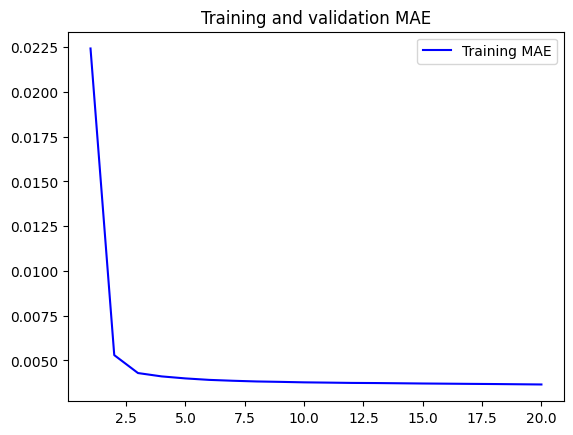

In [689]:
loss = history.history['loss'] 
#val_loss = history.history['val_loss'] 
epochs = range(1, len(loss) + 1) 
plt.figure()
plt.plot(epochs, loss, 'blue', label='Training MAE')
#plt.plot(epochs, val_loss, 'green', label='Validation MAE')
plt.title('Training and validation MAE')
plt.legend()
plt.show()

In [690]:
y_pred = model.predict(X_test) #scaler_y.inverse_transform(model.predict(x_test))
y_true = y_test.reshape(-1, output_dim) #scaler_y.inverse_transform(y_test.reshape(-1, window_dim))

y_pred[y_pred < 0] = 0

error = y_pred - y_true

r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(np.square(error).mean())
mae = np.abs(error).mean()
mape = np.abs(error / y_true).mean() * 100

print("Common error metrics:\n\nR2-Score: {}\nRMSE: {}\nMAE : {}\nMAPE : {}"
      .format(r2, rmse, mae, mape))

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
Common error metrics:

R2-Score: 0.8620041093017803
RMSE: 0.07095233526456395
MAE : 0.04752723344481636
MAPE : nan


/var/folders/pz/kvbp4_tx4gj8hj2xjrqppmvr0000gn/T/ipykernel_50845/3128049987.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.abs(error / y_true).mean() * 100
/var/folders/pz/kvbp4_tx4gj8hj2xjrqppmvr0000gn/T/ipykernel_50845/3128049987.py:11: RuntimeWarning: invalid value encountered in divide
  mape = np.abs(error / y_true).mean() * 100


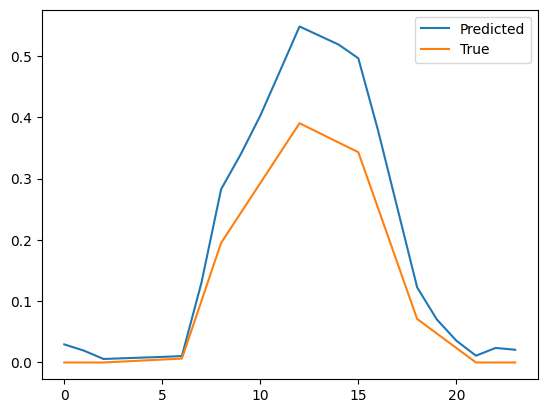

In [691]:
i = 2
#plt.plot(y_pred[24*i], label='Predicted')
#plt.plot(y_true[24*i], label='True')
plt.plot(y_pred[24*i:24*(i+1)], label='Predicted')
plt.plot(y_true[24*i:24*(i+1)], label='True')

plt.legend()

In [692]:
df_error = pd.DataFrame(data={'Hour': df[test_start:].index.hour.values,
                              'Errors': error.reshape(-1)})

Text(0, 0.5, 'Error in NAME')

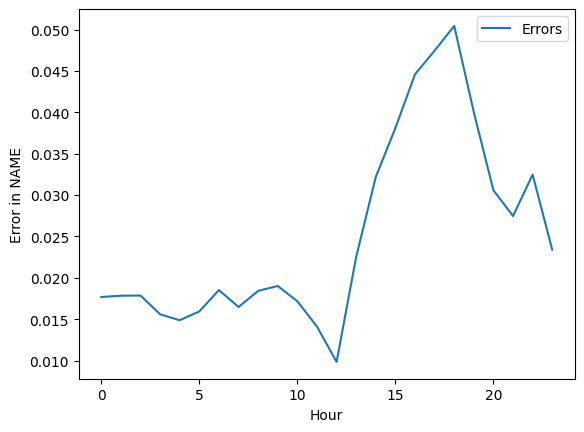

In [693]:
df_error.groupby('Hour').mean().plot()
plt.ylabel('Error in NAME')